# CSC52087EP lab1a by Vicky Kalogeiton
# Ecole Polytechnique
# Basic GAN Notebook

In [31]:
# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch_directml

ImportError: DLL load failed while importing torch_directml_native: La procédure spécifiée est introuvable.

## Setup

In [17]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 x 784 (Batch size = 128, 28*28 = 784)
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 784 --> 128 x 1 x 28 x 28
  # matplotlib has a different order (Width ,Height ,Channels) than pytorch for images
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)   # 1 x 28 x 28  = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()


In [18]:
# setup of the main parameters and hyperparameters
epochs = 200
cur_step = 0
# every how many steps we want to show information on the screen
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

#dimensionality of noise vector that is the input of the generator
z_dim = 64
# learning rate
lr = 0.00001
# Binary Cross Entropy with Logits (transfoms the output wiht a sigmoid from 0 to 1)
loss_func = nn.BCEWithLogitsLoss()

# batch size
bs = 128
device = 'cuda'

# 1. where to store the data (.), 2. download the data = True 3. tranform according to the Tensor structure
# 4. shuffle: at every epoch we shuffle the data, 5. batch size
dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)

# every epoch is going to have number of steps:
# number of steps = 60000 / 128 = 468.75

## Declare the models
#### Fill in the missing blanks

In [19]:
# Generator
def generatorBlock(input, output):
  return nn.Sequential(
    nn.Linear(input, output),
    nn.BatchNorm1d(output),
    nn.ReLU(),
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, image_dim=784, h_dim=128): # z_dim: latent space dimensionality
    super().__init__()
    self.generator = nn.Sequential( # Fill in the rest by using the z_dim and the h_dim
        generatorBlock(z_dim, h_dim), # 64 --> 128
        generatorBlock(h_dim, h_dim*2), # 128 --> 256
        generatorBlock(h_dim*2, h_dim*4), # 256 --> 512
        generatorBlock(h_dim*4, h_dim*8), # 512 --> 1024
        generatorBlock(h_dim*8, image_dim), # 1024 --> 784
        nn.Sigmoid(), # to make the values between 0 and 1
    )

  def forward(self, noise):
       return self.generator(noise)

# function that generates noise
def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

In [20]:
## Discriminator
def discriminatorBlock(input, output):
  return nn.Sequential(
    nn.Linear(input, output),
    nn.LeakyReLU(0.2),
  )

class Discriminator(nn.Module):
  def __init__(self, image_dim=784, h_dim=256):
    super().__init__()
    self.discriminator=nn.Sequential( # Fill in the rest by using the image_dim and the h_dim
        discriminatorBlock(image_dim, h_dim*4), # 784 --> 1024 
        discriminatorBlock(h_dim*4, h_dim*2), # 1024 --> 512
        discriminatorBlock(h_dim*2, h_dim), # 512 --> 256
        nn.Linear(h_dim, 1) # output: 256 --> 1
    )

  def forward(self, image):
      return self.discriminator(image)

## Main code

In [21]:
gen = Generator(z_dim).to(device)
# optimizer of the generator
gen_opt = optim.Adam(gen.parameters(), lr=lr) # Adam optimizer
disc = Discriminator().to(device)
# optimizer of the discriminator
disc_opt = optim.Adam(disc.parameters(), lr=lr) # Adam optimizer

AssertionError: Torch not compiled with CUDA enabled

In [8]:
# check your generator
gen

NameError: name 'gen' is not defined

In [9]:
# check your discriminator
disc

NameError: name 'disc' is not defined

In [ ]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([1, 3, 2, 9, 7, 0, 2, 6, 2, 6])


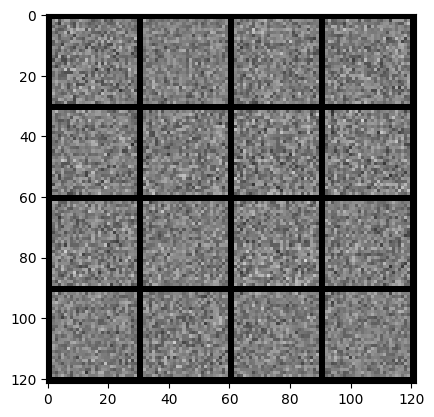

In [ ]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

# Here we see the initial output of passing the noise through the generator
# Since the generator did not start learning, it produces a very noisy output

## Compute the loss

In [ ]:
# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim): # number is the number of elemenent we want to process, i.e. batch size
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred) # 1: real, 0: fake
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   # number is the number of elemenent we want to process, i.e. batch size
   # real is the number of real images
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach()) # need to detach so that we do not change the generator
   disc_fake_targets=torch.zeros_like(disc_fake) # 1: real, 0: fake
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss





**GANs are known for their training instability and difficulty in achieving convergence. Discuss the potential causes of these issues**

## Training loop

In [ ]:
### batch size = 128
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    TODO, # set the gradients to zero


    current_batch_size=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(current_batch_size, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,current_batch_size,real,z_dim)
    TODO, # Backpropagation
    TODO, # Optimizer step

    ### generator
    TODO, # set the gradients to zero
    gen_loss = calc_gen_loss(loss_func,gen,disc,current_batch_size,z_dim)
    TODO, # Backpropagation
    TODO, # Optimizer step

    ### statistics + visualization

    # adding the values into the losses
    mean_disc_loss+=disc_loss.item()/info_step # .item() transforms the tensor value into a standalone value
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(current_batch_size, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1


**In the quantitative assessment of GANs, especially for complex image datasets, which metrics are suitable for evaluating the quality and diversity of the generated images?**